## 전처리

In [8]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
import cv2
import pandas as pd
import ast
from tqdm import tqdm
import re
from sklearn.model_selection import KFold

# ==========================================
# [설정] 경로 및 파라미터
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'

DICOM_ROOT_DIRS = [
    os.path.join(BASE_DIR, '1_mask_and_box', 'train_images'),
    os.path.join(BASE_DIR, '3_only_box', 'train_images'),
    # os.path.join(BASE_DIR, 'train_images') # 필요시 주석 해제
]

MASK_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks') 
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv')

# 저장 경로
OUTPUT_DIR = os.path.join(BASE_DIR, 'detection_cropped_512') 

# [출력 1] 전체 데이터 매니페스트 (백업용)
OUTPUT_MANIFEST_FULL = os.path.join(BASE_DIR, 'det_train_manifest_cropped_full.csv')
# [출력 2] 1:1 균형 매니페스트 (학습용)
OUTPUT_MANIFEST_BALANCED = os.path.join(BASE_DIR, 'det_train_manifest_balanced_1to1.csv')

WL, WW = 500, 2000
TARGET_SIZE = 512
MARGIN_RATIO = 0.2 

# ==========================================
# [함수] 유틸리티
# ==========================================
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

def get_mask_bbox(mask_slice):
    rows = np.any(mask_slice > 0, axis=1)
    cols = np.any(mask_slice > 0, axis=0)
    if not np.any(rows) or not np.any(cols): return None
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max

def make_square_box(x1, y1, x2, y2, img_w, img_h, margin=0.2):
    w = x2 - x1
    h = y2 - y1
    cx, cy = x1 + w // 2, y1 + h // 2
    max_side = max(w, h)
    new_size = int(max_side * (1 + margin))
    half_size = new_size // 2
    new_x1 = max(0, cx - half_size)
    new_y1 = max(0, cy - half_size)
    new_x2 = min(img_w, cx + half_size)
    new_y2 = min(img_h, cy + half_size)
    if new_x2 <= new_x1 or new_y2 <= new_y1: return 0, 0, img_w, img_h
    return int(new_x1), int(new_y1), int(new_x2), int(new_y2)

def get_slice_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

# ==========================================
# [메인] Safe Crop & Balance
# ==========================================
def process_safe_crop_and_balance():
    if not os.path.exists(BBOX_CSV_PATH):
        print(f"❌ 라벨 파일이 없습니다.")
        return
    
    bbox_df = pd.read_csv(BBOX_CSV_PATH)
    print(f"📖 라벨 데이터 로드: {len(bbox_df)} boxes")

    available_masks = [f.replace('_mask.nii.gz', '') for f in os.listdir(MASK_DIR) if f.endswith('_mask.nii.gz')]
    uids_to_process = sorted(list(set(available_masks)))
    
    new_rows = []
    
    print(f"🚀 [Safe Crop] 박스 포함 전처리 시작")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- 1. 전처리 루프 (Safe Crop) ---
    for uid in tqdm(uids_to_process):
        dicom_dir = None
        for root in DICOM_ROOT_DIRS:
            temp_path = os.path.join(root, uid)
            if os.path.exists(temp_path):
                dicom_dir = temp_path
                break
        if dicom_dir is None: continue 

        try:
            # 메타데이터 로드
            dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
            dcm_meta = []
            for f in dcm_files:
                slice_num = get_slice_number(f)
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                dcm_meta.append({
                    'filename': f, 'full_path': os.path.join(dicom_dir, f),
                    'slice_number': slice_num, 
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'slope': float(getattr(ds, 'RescaleSlope', 1.0)),
                    'intercept': float(getattr(ds, 'RescaleIntercept', 0.0))
                })
            dcm_meta.sort(key=lambda x: x['z_pos'], reverse=True)
            
            # 볼륨 & 마스크 로드
            full_vol = []
            for m in dcm_meta:
                ds = pydicom.dcmread(m['full_path'])
                px = ds.pixel_array.astype(np.float32) * m['slope'] + m['intercept']
                full_vol.append(apply_windowing(px, WL, WW))
            full_vol = np.stack(full_vol, axis=0)
            
            mask_path = os.path.join(MASK_DIR, f"{uid}_mask.nii.gz")
            mask_itk = sitk.ReadImage(mask_path)
            mask_vol = sitk.GetArrayFromImage(mask_itk).astype(np.uint8)
            mask_vol = np.flip(mask_vol, axis=(0, 1))

            pat_bbox_df = bbox_df[bbox_df['StudyInstanceUID'] == uid]

            # 슬라이스 처리
            patient_save_dir = os.path.join(OUTPUT_DIR, uid)
            os.makedirs(patient_save_dir, exist_ok=True)
            
            for z_idx, meta in enumerate(dcm_meta):
                current_slice_num = meta['slice_number']
                if z_idx >= len(mask_vol): break
                m_slice = mask_vol[z_idx]
                
                # 마스크 박스
                mask_bbox = get_mask_bbox(m_slice)
                if mask_bbox is None: continue
                mx1, my1, mx2, my2 = mask_bbox
                
                # Safe Crop Logic: 정답 박스 포함하여 영역 확장
                relevant_boxes = pat_bbox_df[pat_bbox_df['slice_number'] == current_slice_num]
                
                final_x1, final_y1, final_x2, final_y2 = mx1, my1, mx2, my2
                
                if len(relevant_boxes) > 0:
                    for _, row in relevant_boxes.iterrows():
                        bx, by, bw, bh = row['x'], row['y'], row['width'], row['height']
                        bx2, by2 = bx + bw, by + bh
                        final_x1 = min(final_x1, bx)
                        final_y1 = min(final_y1, by)
                        final_x2 = max(final_x2, bx2)
                        final_y2 = max(final_y2, by2)
                
                ori_h, ori_w = m_slice.shape
                cx1, cy1, cx2, cy2 = make_square_box(final_x1, final_y1, final_x2, final_y2, ori_w, ori_h, MARGIN_RATIO)
                crop_w, crop_h = cx2 - cx1, cy2 - cy1
                if crop_w == 0: continue
                
                # 이미지 크롭 (3채널)
                z_prev = max(0, z_idx - 1)
                z_next = min(len(full_vol) - 1, z_idx + 1)
                img_3ch = np.stack([full_vol[z_prev], full_vol[z_idx], full_vol[z_next]], axis=0) 
                
                cropped_3ch = img_3ch[:, cy1:cy2, cx1:cx2]
                cropped_hwc = np.transpose(cropped_3ch, (1, 2, 0))
                resized_hwc = cv2.resize(cropped_hwc, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
                final_data = np.transpose(resized_hwc, (2, 0, 1)) 
                
                # BBox 변환
                is_fracture = 0
                new_bboxes = []
                
                if len(relevant_boxes) > 0:
                    is_fracture = 1
                    scale_x = TARGET_SIZE / crop_w
                    scale_y = TARGET_SIZE / crop_h
                    for _, row in relevant_boxes.iterrows():
                        bx, by, bw, bh = row['x'], row['y'], row['width'], row['height']
                        new_x = (bx - cx1) * scale_x
                        new_y = (by - cy1) * scale_y
                        new_w = bw * scale_x
                        new_h = bh * scale_y
                        
                        norm_x = new_x / TARGET_SIZE
                        norm_y = new_y / TARGET_SIZE
                        norm_w = new_w / TARGET_SIZE
                        norm_h = new_h / TARGET_SIZE
                        
                        if (norm_x + norm_w > 0) and (norm_y + norm_h > 0) and (norm_x < 1) and (norm_y < 1):
                            new_bboxes.append([norm_x, norm_y, norm_w, norm_h])
                
                # 저장
                file_name = f"{z_idx:04d}.npz" 
                save_path = os.path.join(patient_save_dir, file_name)
                np.savez_compressed(save_path, data=final_data)
                
                new_rows.append({
                    'StudyInstanceUID': uid, 'slice_idx': z_idx,
                    'original_slice_number': current_slice_num,
                    'file_path': os.path.join('detection_cropped_512', uid, file_name),
                    'fracture': is_fracture,
                    'bbox': str(new_bboxes),
                    'ver_level': 0
                })
                
        except Exception as e:
            print(f"❌ Error {uid}: {e}")
            continue

    # --- 2. 1:1 밸런싱 로직 (추가됨) ---
    full_df = pd.DataFrame(new_rows)
    print(f"\n📊 전체 데이터 생성 완료: {len(full_df)}개")
    
    # K-Fold 먼저 나눕니다 (Fold는 전체 데이터 기준으로 나누는 게 안전)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    full_df['fold'] = -1
    unique_uids = full_df['StudyInstanceUID'].unique()
    for f_idx, (_, val_idx) in enumerate(kf.split(unique_uids), 1):
        full_df.loc[full_df['StudyInstanceUID'].isin(unique_uids[val_idx]), 'fold'] = f_idx
    
    # 전체 저장 (백업용)
    full_df.to_csv(OUTPUT_MANIFEST_FULL, index=False)
    print(f"📁 전체 매니페스트 저장됨: {OUTPUT_MANIFEST_FULL}")

    print("⚖️ 1:1 균형 맞추기 시작...")
    
    # 골절(Positive)과 정상(Negative) 분리
    pos_df = full_df[full_df['fracture'] == 1].reset_index(drop=True)
    neg_df = full_df[full_df['fracture'] == 0].reset_index(drop=True)
    
    pos_count = len(pos_df)
    neg_count = len(neg_df)
    
    print(f"   - Fracture: {pos_count}")
    print(f"   - Normal: {neg_count}")
    
    # Undersampling (Normal을 Fracture 개수만큼 랜덤 추출)
    if neg_count > pos_count:
        neg_sampled = neg_df.sample(n=pos_count, random_state=42).reset_index(drop=True)
    else:
        neg_sampled = neg_df # 혹시 정상이 더 적으면 다 씀
        
    balanced_df = pd.concat([pos_df, neg_sampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
    
    # 1:1 결과 저장
    balanced_df.to_csv(OUTPUT_MANIFEST_BALANCED, index=False)
    
    print(f"\n✅ [Complete] 1:1 학습용 데이터셋 준비 완료!")
    print(f"   - 총 데이터: {len(balanced_df)} (골절 {pos_count} : 정상 {len(neg_sampled)})")
    print(f"   - 학습에 사용할 매니페스트: {OUTPUT_MANIFEST_BALANCED}")

if __name__ == '__main__':
    process_safe_crop_and_balance()

📖 라벨 데이터 로드: 7217 boxes
🚀 [Safe Crop] 박스 포함 전처리 시작


100%|██████████| 235/235 [1:38:15<00:00, 25.09s/it]


📊 전체 데이터 생성 완료: 49611개
📁 전체 매니페스트 저장됨: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_cropped_full.csv
⚖️ 1:1 균형 맞추기 시작...
   - Fracture: 7190
   - Normal: 42421

✅ [Complete] 1:1 학습용 데이터셋 준비 완료!
   - 총 데이터: 14380 (골절 7190 : 정상 7190)
   - 학습에 사용할 매니페스트: C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_balanced_1to1.csv


## 전처리 검증

📊 골절 샘플 수: 7190
👀 랜덤으로 5장을 뽑아서 검증합니다... (RGB 모드)


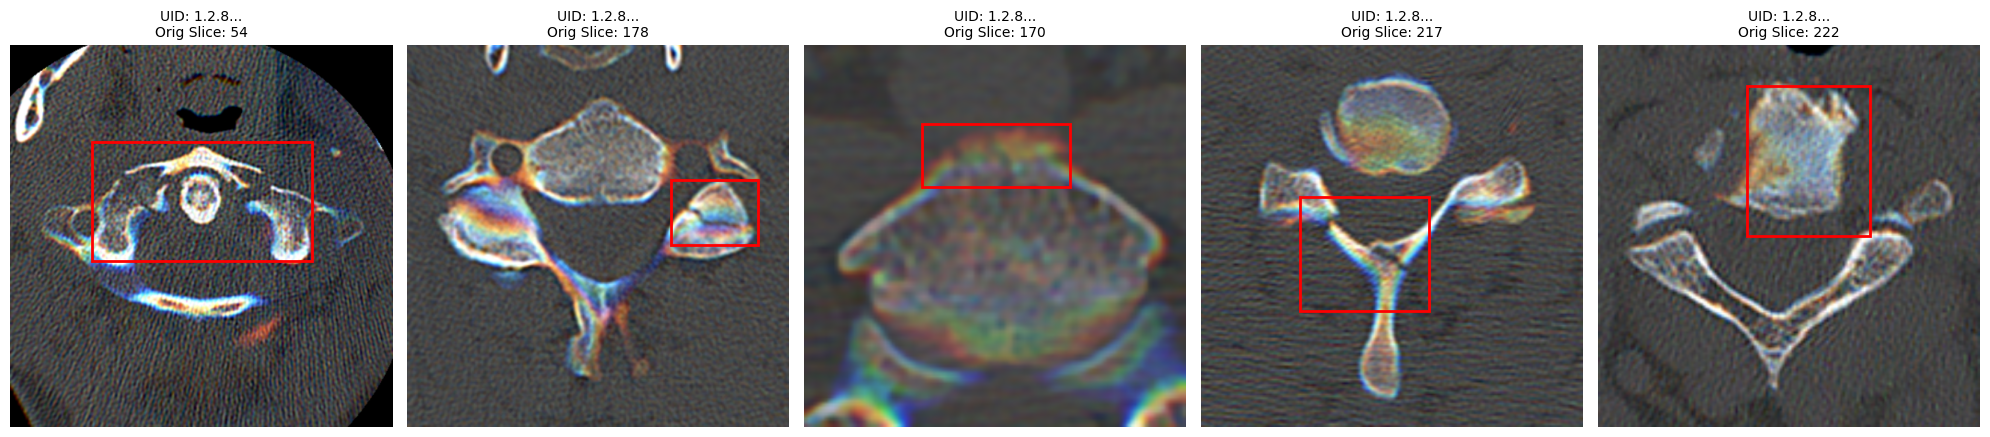

✨ 검증 포인트:
1. 이미지가 흑백 같지만 미세하게 입체감(RGB)이 느껴지나요? (2.5D 특징)
2. 척추가 화면 중앙에 꽉 차게 보이나요? (Zoom-in 성공)
3. 빨간 박스가 골절 부위를 정확히 감싸고 있나요?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import ast

# ==========================================
# [설정] 경로
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
# 3채널 크롭 매니페스트 경로
MANIFEST_PATH = os.path.join(BASE_DIR, 'det_train_manifest_balanced_1to1.csv')

def visualize_3ch_dataset():
    if not os.path.exists(MANIFEST_PATH):
        print(f"❌ 매니페스트 파일이 없습니다: {MANIFEST_PATH}")
        return

    df = pd.read_csv(MANIFEST_PATH)
    
    # 골절이 있는 샘플만 필터링 (박스 확인용)
    fracture_df = df[df['fracture'] == 1]
    
    if len(fracture_df) == 0:
        print("❌ 골절 샘플이 없습니다.")
        return

    print(f"📊 골절 샘플 수: {len(fracture_df)}")
    print("👀 랜덤으로 5장을 뽑아서 검증합니다... (RGB 모드)")

    # 랜덤 5장 샘플링
    samples = fracture_df.sample(n=min(5, len(fracture_df)), random_state=42)
    
    plt.figure(figsize=(20, 5))
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        ax = plt.subplot(1, 5, idx + 1)
        
        full_path = os.path.join(BASE_DIR, row['file_path'])
        
        try:
            # 1. NPZ 로드
            with np.load(full_path) as loaded:
                # Shape: (3, 512, 512) -> (R=z-1, G=z, B=z+1)
                data = loaded['data']
            
            # 2. 시각화를 위해 (C, H, W) -> (H, W, C)로 변환
            img_rgb = np.transpose(data, (1, 2, 0))
            
            # 0~1 범위를 벗어날 경우를 대비해 안전하게 클리핑 (화면 깨짐 방지)
            img_rgb = np.clip(img_rgb, 0, 1)
            
            # 3. 이미지 그리기
            ax.imshow(img_rgb)
            
            # 4. BBox 그리기 (Red)
            if pd.notna(row['bbox']):
                # 포맷: "[[x, y, w, h], ...]" (Normalized 0~1)
                boxes = ast.literal_eval(row['bbox'])
                
                for box in boxes:
                    nx, ny, nw, nh = box
                    
                    # Normalized -> Pixel (512)
                    x = nx * 512
                    y = ny * 512
                    w = nw * 512
                    h = nh * 512
                    
                    # 박스 그리기
                    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
            
            # 제목
            title_txt = f"UID: {row['StudyInstanceUID'][:5]}..."
            if 'original_slice_number' in row:
                title_txt += f"\nOrig Slice: {row['original_slice_number']}"
            ax.set_title(title_txt, fontsize=10)
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{str(e)}", ha='center', color='red')
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    print("✨ 검증 포인트:")
    print("1. 이미지가 흑백 같지만 미세하게 입체감(RGB)이 느껴지나요? (2.5D 특징)")
    print("2. 척추가 화면 중앙에 꽉 차게 보이나요? (Zoom-in 성공)")
    print("3. 빨간 박스가 골절 부위를 정확히 감싸고 있나요?")

if __name__ == '__main__':
    visualize_3ch_dataset()

## 학습

In [9]:
import os
# --- [1. OpenMP 에러 방지] ---
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
import yaml
from pathlib import Path
import cv2

# Ultralytics 공식 트레이너 관련
from ultralytics import YOLO
from ultralytics.models.yolo.detect import DetectionTrainer

# ==========================================
# 2. 설정 (Configuration)
# ==========================================
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset',
    
    # [핵심] 방금 만든 3채널 크롭 매니페스트 경로
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_balanced_1to1.csv',
    
    # [모델] Medium 모델 사용 (순정 가중치 사용 가능!)
    # 가지고 계신 파일명이 'yolo26m.pt'라면 그걸로 수정하세요. 없으면 'yolov8m.pt' 자동 다운로드.
    'pretrained_model': 'yolo26m.pt', 
    
    'save_dir_root': './runs/rsna_cropped_det', # 저장 경로 (3ch 표시)
    'img_size': 640,
    
    # [메모리 주의] Medium 모델은 무거우므로 8 추천. 
    # 만약 VRAM 남으면 16, 부족하면 4로 조절하세요.
    'batch_size': 8,
    
    'epochs': 100,
    'patience': 30,
    'workers': 0,
    'folds_to_run': [1] # 테스트로 1번 폴드만 먼저 실행
}

def create_dummy_structure(base_dir):
    fake_dirs = [
        os.path.join(base_dir, 'images', 'train'), os.path.join(base_dir, 'images', 'val'),
        os.path.join(base_dir, 'labels', 'train'), os.path.join(base_dir, 'labels', 'val')
    ]
    for d in fake_dirs: os.makedirs(d, exist_ok=True)

# ==========================================
# 3. 데이터셋 (3채널 대응)
# ==========================================
class RSNA3ChannelDataset(Dataset):
    def __init__(self, df, base_dir, img_size=640): # CONFIG의 640을 받음
        self.df = df
        self.base_dir = base_dir
        self.img_size = img_size
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['file_path'])
        
        # 1. 이미지 로드 (전처리된 512px, 3채널 데이터)
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32) # (3, 512, 512)
        except:
            img = np.zeros((3, self.img_size, self.img_size), dtype=np.float32)

        # 2. CLAHE 적용 (선명도 강화)
        img_uint8 = (img * 255).astype(np.uint8)
        channels = []
        for i in range(3):
            channels.append(self.clahe.apply(img_uint8[i]))
        img_enhanced = np.stack(channels, axis=0) # (3, 512, 512)

        # 3. [핵심] 512px -> 640px 리사이즈 로직
        # cv2.resize는 (H, W, C)를 원하므로 Transpose 필요
        img_hwc = np.transpose(img_enhanced, (1, 2, 0)) # (512, 512, 3)
        
        # 실제 리사이즈 수행
        img_resized = cv2.resize(img_hwc, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)
        
        # 다시 (3, 640, 640)으로 복구 및 0~1 정규화
        img_final = np.transpose(img_resized, (2, 0, 1)).astype(np.float32) / 255.0

        # 이미지 크기 정보 업데이트 (640, 640)
        h, w = self.img_size, self.img_size

        # 4. 박스 처리 (Single Class 적용)
        boxes = [] 
        if int(float(row['fracture'])) == 1 and pd.notna(row['bbox']):
            try:
                raw_boxes = row['bbox']
                if isinstance(raw_boxes, str):
                    if 'np.float64' in raw_boxes:
                        raw_boxes = raw_boxes.replace('np.float64(', '').replace(')', '')
                    raw_boxes = ast.literal_eval(raw_boxes)
                
                if isinstance(raw_boxes, list):
                    for box in raw_boxes:
                        if len(box) == 4:
                            x, y, w_box, h_box = box
                            cx = x + w_box / 2
                            cy = y + h_box / 2
                            
                            # [수정] 무조건 0번 클래스(fracture)로 고정
                            cls = 0 
                                
                            boxes.append([cls, cx, cy, w_box, h_box])
            except: pass
        
        # 5. 리턴 (img_tensor 변수 생성 여부는 자유입니다)
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 5))
        img_tensor = torch.from_numpy(img_final) # 이름을 붙여주는 게 가독성이 더 좋습니다.
        
        return img_tensor, boxes, (h, w), full_path

# [학습용] Ultralytics 포맷 Collate
def trainer_collate_fn(batch):
    images, box_lists, shapes, paths = zip(*batch)
    images = torch.stack(images, 0)
    
    new_boxes = []
    for i, boxes in enumerate(box_lists):
        if boxes.shape[0] > 0:
            idx_col = torch.full((boxes.shape[0], 1), i, dtype=torch.float32)
            combined = torch.cat([idx_col, boxes], dim=1)
            new_boxes.append(combined)
    targets = torch.cat(new_boxes, 0) if new_boxes else torch.zeros((0, 6))
    
    return {
        'img': images,
        'batch_idx': targets[:, 0],
        'cls': targets[:, 1].view(-1, 1),
        'bboxes': targets[:, 2:],
        'device': None,
        'ori_shape': list(shapes),
        'resized_shape': list(shapes),
        'im_file': list(paths),
        'ratio_pad': [((1.0, 1.0), (0.0, 0.0)) for _ in range(len(images))] 
    }

# [검증용] 단순 Collate
def val_collate_fn(batch):
    images, box_lists, shapes, paths = zip(*batch)
    images = torch.stack(images, 0)
    return images, box_lists, shapes, paths

# ==========================================
# 4. 커스텀 트레이너 (순정 YOLO 사용)
# ==========================================
class RSNATrainer(DetectionTrainer):
    def __init__(self, overrides=None, current_fold=1):
        self.current_fold = current_fold
        super().__init__(overrides=overrides)

    def build_dataset(self, img_path, mode="train", batch=None):
        df = pd.read_csv(CONFIG['manifest_path'])
        if mode == "train":
            sub_df = df[df['fold'] != self.current_fold].reset_index(drop=True)
        else:
            sub_df = df[df['fold'] == self.current_fold].reset_index(drop=True)
            
        print(f"Dataset Build ({mode}): {len(sub_df)} samples loaded.")
        return RSNA3ChannelDataset(sub_df, CONFIG['base_dir'], img_size=CONFIG['img_size'])

    def get_dataloader(self, dataset_path, batch_size=16, rank=0, mode="train"):
        # 3채널이므로 channel 설정을 강제할 필요 없음 (기본값 사용)
        dataset = self.build_dataset(dataset_path, mode)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=(mode == "train"),
                            num_workers=0, collate_fn=trainer_collate_fn, pin_memory=True)
        loader.reset = lambda: None
        return loader

    # get_model 오버라이드 삭제! -> 순정 모델 로드 로직 그대로 사용

    def final_eval(self):
        print("⚠️ [Info] Ultralytics 내부 final_eval 건너뜀")
        return

    def plot_training_labels(self, *args, **kwargs): pass 

# ==========================================
# 5. 커스텀 메트릭 (수정됨: YOLO 클래스로 직접 로드)
# ==========================================
def calculate_custom_metrics(model_path, val_fold, device):
    print(f"\n📊 [Fold {val_fold}] 커스텀 메트릭 계산 시작...")
    
    # 데이터셋 로드
    df = pd.read_csv(CONFIG['manifest_path'])
    val_df = df[df['fold'] == val_fold].reset_index(drop=True)
    val_ds = RSNA3ChannelDataset(val_df, CONFIG['base_dir'])
    
    # DataLoader (순서 섞지 않음)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, 
                            num_workers=0, collate_fn=val_collate_fn)

    if os.path.exists(model_path):
        # [핵심 변경] Trainer를 거치지 않고 YOLO 클래스로 직접 로드 (에러 해결)
        try:
            # 저장된 가중치 파일(.pt)에는 모델 구조(cfg)가 포함되어 있어 바로 로드 가능
            best_model = YOLO(str(model_path)) 
            model = best_model.model # 내부 PyTorch 모델 추출
        except Exception as e:
            print(f"❌ 모델 로드 중 에러 발생: {e}")
            return 0.0, 0.0
    else:
        print(f"❌ [Critical] 가중치 파일 없음: {model_path}")
        return 0.0, 0.0

    model.to(device)
    model.eval()

    preds_prob = []
    targets = []

    print(f"   ▶ 추론 진행 중... (Total: {len(val_loader)} batches)")
    
    with torch.no_grad():
        for img, boxes, _, _ in val_loader:
            img = img.to(device)
            
            # 모델 추론
            output = model(img)
            
            # YOLOv8 출력 처리
            # output이 리스트/튜플로 나올 경우 첫 번째 요소가 추론 결과
            if isinstance(output, (list, tuple)):
                output = output[0]
                
            # (Batch, Anchors, 4+Cls) 형태로 변환
            pred_tensor = output.transpose(1, 2) 
            
            for i in range(len(img)):
                p = pred_tensor[i]
                # p: (Anchors, [x, y, w, h, cls1, cls2...])
                # 4번째 인덱스부터가 클래스 확률
                cls_probs = p[:, 4:] 
                
                # 각 앵커별로 가장 높은 클래스 확률을 구함
                conf, _ = cls_probs.max(1)
                
                # 이미지 한 장에서 발견된 박스 중 '가장 높은 확률'을 해당 슬라이스의 골절 확률로 간주
                # (가장 보수적인 기준)
                preds_prob.append(conf.max().item())
            
            # 정답 처리 (박스가 하나라도 있으면 골절=1.0)
            for b in boxes:
                targets.append(1.0 if b.shape[0] > 0 else 0.0)

    preds_prob = np.array(preds_prob)
    targets = np.array(targets)
    
    # Accuracy & LogLoss 계산
    # 예측 확률이 0.5 이상이면 골절로 예측했다고 가정
    acc = ((preds_prob > 0.5) == targets).mean()
    
    # LogLoss 계산 시 log(0) 방지를 위해 엡실론 클리핑
    epsilon = 1e-15
    preds_prob = np.clip(preds_prob, epsilon, 1 - epsilon)
    log_loss = -(targets * np.log(preds_prob) + (1 - targets) * np.log(1 - preds_prob)).mean()

    print(f"   👉 Accuracy: {acc:.4f}")
    print(f"   👉 Log Loss: {log_loss:.4f}")
    
    return acc, log_loss

# [추가] 에폭이 완전히 끝날 때 Trainer의 결과 바구니에서 Val Loss를 꺼내오는 함수
def print_val_metrics(trainer):
    try:
        # validator가 아니라 trainer 자체의 metrics(순수 딕셔너리)에 접근합니다.
        metrics = trainer.metrics 
        
        if metrics:
            val_box = metrics.get('val/box_loss', 0.0)
            val_cls = metrics.get('val/cls_loss', 0.0)
            val_dfl = metrics.get('val/dfl_loss', 0.0)
            
            print(f"\n   [📊 Validation Loss] Box: {val_box:.4f} | Cls: {val_cls:.4f} | DFL: {val_dfl:.4f}\n")
    except Exception:
        # 만약 YOLO 버전 차이로 내부 구조가 달라서 또 에러가 나더라도, 
        # 학습 자체는 멈추지 않고 그냥 조용히 넘어가도록 방어막을 칩니다.
        pass

# ==========================================
# 6. 메인 실행
# ==========================================
if __name__ == '__main__':
    # 1. 저장 폴더 생성
    save_root_abs = os.path.abspath(CONFIG['save_dir_root'])
    os.makedirs(save_root_abs, exist_ok=True)
    
    create_dummy_structure(CONFIG['base_dir'])
    
    # 2. YAML 생성 (Single Class 수정!)
    current_dir = os.getcwd()
    dummy_yaml_path = os.path.abspath(os.path.join(current_dir, "rsna_dummy.yaml"))
    
    with open(dummy_yaml_path, 'w') as f:
        yaml.dump({
            'path': os.path.abspath(CONFIG['base_dir']), 
            'train': 'images/train', 
            'val': 'images/val',
            
            # [수정] 여기가 핵심입니다!
            'nc': 1,               # 클래스 개수 1개
            'names': ['fracture'], # 이름은 'fracture' 하나로 통일
            
            'ch': 3  # 3채널 유지
        }, f)

    final_results = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    if not os.path.exists(CONFIG['manifest_path']):
        print(f"❌ [Error] 매니페스트 파일이 없습니다: {CONFIG['manifest_path']}")
        exit()

    print(f"🔥 학습 시작! (Dataset: Cropped 3-Channel 640px)")
    print(f"🤖 모델: {CONFIG['pretrained_model']} (Medium)")

    for fold in CONFIG['folds_to_run']:
        print(f"\n{'='*40}")
        print(f"🚀 FOLD {fold} 학습 시작")
        print(f"{'='*40}")
        
        project_path = os.path.abspath(CONFIG['save_dir_root'])
        name_path = f'fold_{fold}'
        
        args = dict(
            model=CONFIG['pretrained_model'], 
            data=dummy_yaml_path, 
            epochs=CONFIG['epochs'],
            batch=CONFIG['batch_size'], 
            imgsz=CONFIG['img_size'], 
            device=0 if device == 'cuda' else 'cpu',
            project=project_path,
            name=name_path, 
            exist_ok=True, workers=0,
            val=True, plots=True, amp=True, save=True,
            
            # --- [핵심 수정: 모델 성격 개조] ---
            patience=30,
            
            # 1. Box Loss (박스 좌표) 가중치 대폭 상향
            # 7.5 -> 15.0 (박스 위치 못 맞추면 크게 혼남)
            box=15.0, 
            
            # 2. Class Loss (골절 유무) 가중치 상향
            # 0.5 -> 2.0 (골절인데 아니라고 하면 크게 혼남)
            cls=2.0, 
            
            # 3. DFL Loss (박스 경계 정밀도)
            # 1.5 -> 2.5 (미세한 금이라 경계가 중요함)
            dfl=2.5,

            # 4. Augmentation (약간의 노이즈 추가)
            # Mosaic은 끄지만, MixUp을 살짝 켜서 "겹쳐 보이는 뼈"에 익숙해지게 함
            mosaic=0.0, 
            mixup=0.0,       # 0.0 -> 0.1 (약하게 켬)
            copy_paste=0.0,
            
            # HSV (색감) 변화: 3채널(2.5D)의 깊이 정보에 강건해지도록
            hsv_h=0.015,
            hsv_s=0.2,       # 조금 더 다양하게 보게 함
            hsv_v=0.2,

            # 5. [중요] Warmup (초반 예열)
            # Batch가 4로 작으므로, 초반에 학습률을 천천히 올려야 발산 안 함
            warmup_epochs=3.0, 
            lr0=0.001,      # 초기 학습률 살짝 낮춤 (0.01 -> 0.005)
            lrf=0.01,      # 최종 학습률도 낮춤 (천천히 꼼꼼하게 보라고)

            
            # ... 기존 설정들 유지 ...
            
            # 🛡️ [추가] 1. 드롭아웃 (과적합 방지 최고 존엄)
            # 신경망 연결을 20% 무작위로 끊어서 억지로 외우는 걸 방지함
            dropout=0.2, 
            
            # 🛡️ [추가] 2. 의료 영상 맞춤형 데이터 증강
            degrees=5.0,        # 척추가 너무 휘지 않게 살짝만(5도) 회전
            translate=0.1,      # 상하좌우로 10%씩 살짝 이동
            scale=0.1,          # 크기를 10% 내외로 확대/축소
            fliplr=0.5,         # 좌우 반전 (척추는 좌우 대칭이므로 아주 효과적임)
            erasing=0.2,        # Random Erasing: 이미지의 일부를 무작위로 검게 가림 (박스 의존성 낮춤)
            
        
        
        )

        # 트레이너 생성
        trainer = RSNATrainer(overrides=args, current_fold=fold)
        
        # 🔗 [핵심] 에폭이 종료되는 시점에 우리가 만든 함수가 무조건 실행되도록 연결!
        trainer.add_callback("on_fit_epoch_end", print_val_metrics)
        
        # 학습 시작
        trainer.train()
        
        real_save_dir = trainer.save_dir 
        best_pt = real_save_dir / 'weights' / 'best.pt'
        if not best_pt.exists():
            best_pt = real_save_dir / 'weights' / 'last.pt'
            
        acc, log_loss = calculate_custom_metrics(best_pt, fold, device)
        
        yolo_res_path = real_save_dir / 'results.csv'
        map50 = 0.0
        if yolo_res_path.exists():
            try:
                res_df = pd.read_csv(yolo_res_path)
                res_df.columns = [c.strip() for c in res_df.columns]
                map50 = res_df['metrics/mAP50(B)'].iloc[-1]
            except: pass

        final_results.append({'fold': fold, 'accuracy': acc, 'log_loss': log_loss, 'mAP50': map50})
        pd.DataFrame(final_results).to_csv(os.path.join(save_root_abs, 'rsna_final_summary.csv'), index=False)

    print(f"\n✨ 학습 완료!")
    print(pd.DataFrame(final_results))

🔥 학습 시작! (Dataset: Cropped 3-Channel 640px)
🤖 모델: yolo26m.pt (Medium)

🚀 FOLD 1 학습 시작
Ultralytics 8.4.14  Python-3.12.12 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=15.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=2.0, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\rsna_dummy.yaml, degrees=5.0, deterministic=True, device=0, dfl=2.5, dnn=False, dropout=0.2, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.2, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.2, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26m.pt,

KeyboardInterrupt: 

## 책갈피